# Timing-associated genes analysis with TimeFateKernel

In our single-cell analysis, we analyse the underlying temporal state in the cell, which we call pseudotime. and identifying the genes associated with pseudotime becomes the key to unravelling models of gene dynamic regulation. In traditional analysis, we would use correlation coefficients, or gene dynamics model fitting. The correlation coefficient approach will have a preference for genes at the beginning and end of the time series, and the gene dynamics model requires RNA velocity information. Unbiased identification of chronosequence-related genes, as well as the need for no additional dependency information, has become a challenge in current chronosequence analyses.

Here, we developed TimeFateKernel, which first removes potential noise from the data through metacells, and then constructs an adaptive ridge regression model to find the minimum set of genes needed to satisfy the timing fit.CellFateGenie has similar accuracy to gene dynamics models while eliminating preferences for the start and end of the time series.

Colab_Reproducibility：https://colab.research.google.com/drive/1Q1Sk5lGCBGBWS5Bs2kncAq9ZbjaDzSR4?usp=sharing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
import scvelo as scv
import matplotlib.pyplot as plt
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 10:30:41 CST


## Data preprocessed

We using dataset of dentategyrus in scvelo to demonstrate the timing-associated genes analysis. Firstly, We use `ov.pp.qc` and `ov.pp.preprocess` to preprocess the dataset.

Then we use `ov.pp.scale` and `ov.pp.pca` to analysis the principal component of the data

In [3]:
import cellrank as cr
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm-rna.h5ad"
adata = ov.read("data/preprocessed_t-cell-depleted-bm-rna.h5ad", backup_url=ad_url)
adata

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

We need to check if the data has been normalized and logarithmized, we find that the maximum value is 13, then the data has been logarithmized.

In [4]:
adata.X.max()

12.226059

/home/huf/my_repo/omicverse/omicverse/utils/_scatterplot.py:483: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'Pseudotime'}, xlabel='X_umap1', ylabel='X_umap2'>]

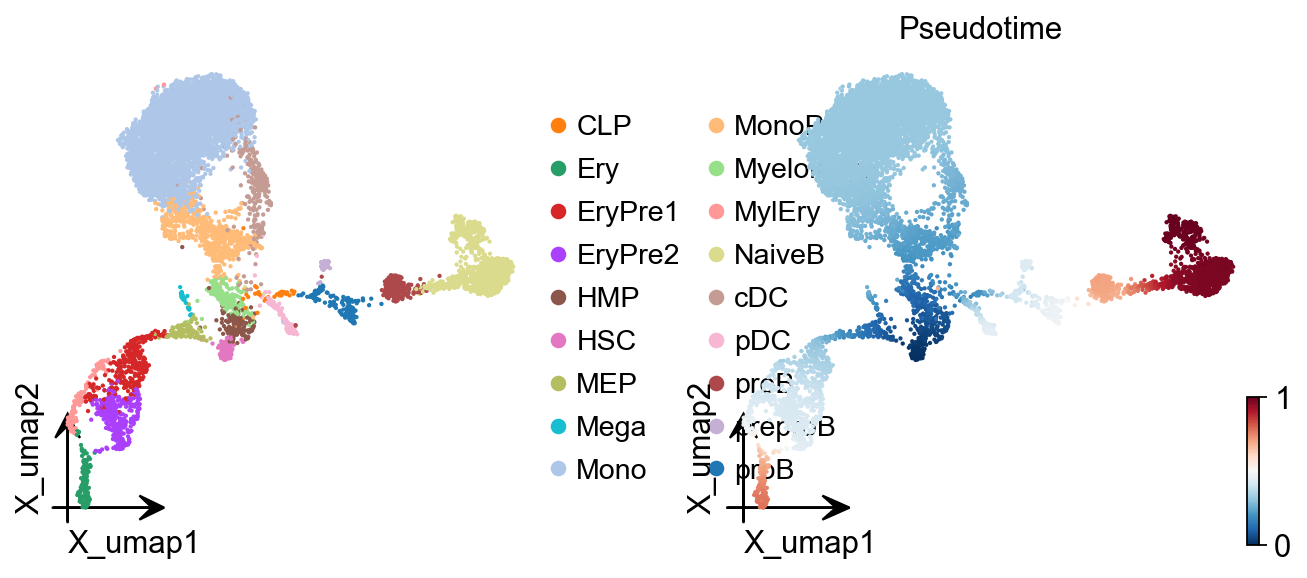

In [5]:
ov.pl.embedding(adata,
                basis="X_umap",
                color=['celltype','palantir_pseudotime'],
                title=['','Pseudotime'],
                size=15,
                show=False, #legend_loc=None, add_outline=False, 
                frameon='small',legend_fontoutline=2,#ax=ax
)

## Initialize the timing model

In TimeFateKernel, we only need to specify the `pseudotime` parameter to automatically fit genes that contribute to pseudotime.

In [7]:
cfg_obj=ov.single.Fate(adata,pseudotime='palantir_pseudotime')
cfg_obj.model_init()
cfg_obj.ATR(stop=500)

$MSE|RMSE|MAE|R^2$:6.5e+01|8.1|6.4|-1.2e+03


  3%|▎         | 499/17225 [01:13<40:47,  6.83it/s]

coef_threshold:0.24426399171352386, r2:-2.457211484156493


,coef_threshold,r2
0,0.244264,-2.457211
1,0.234726,-1.152881
2,0.221914,-1.052316
3,0.218928,-0.944339
4,0.218710,-0.858710
...,...,...
495,0.128732,0.688105
496,0.128703,0.688179
497,0.128657,0.688256
498,0.128614,0.688248


In [8]:
#If the function `plot_filtering` reports an error, specify the threshold manually.
#cfg_obj.coef_threshold=0.001

Text(0.5, 1.0, 'HSC\nTimeFateKernel')

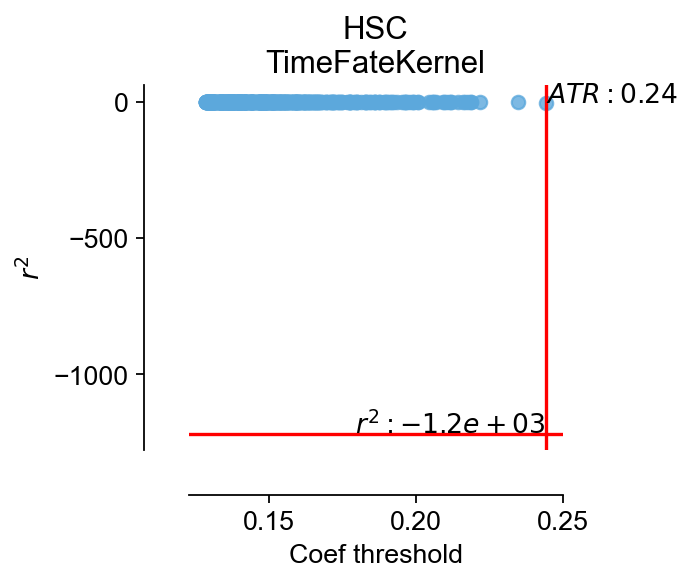

In [9]:
fig,ax=cfg_obj.plot_filtering(color='#5ca8dc')
ax.set_title('HSC\nTimeFateKernel')

In [10]:
res=cfg_obj.model_fit()

$MSE|RMSE|MAE|R^2$:0.053|0.23|0.16|0.0084


(<Figure size 240x240 with 1 Axes>,
 <Axes: title={'center': 'Dimension: 17226'}, xlabel='Raw', ylabel='Predicted'>)

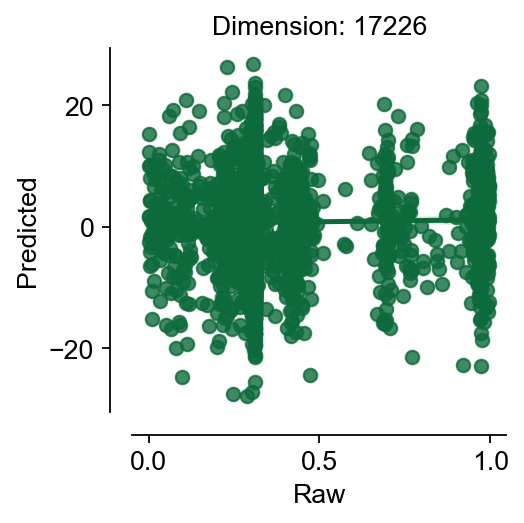

In [11]:
cfg_obj.plot_fitting(type='raw')

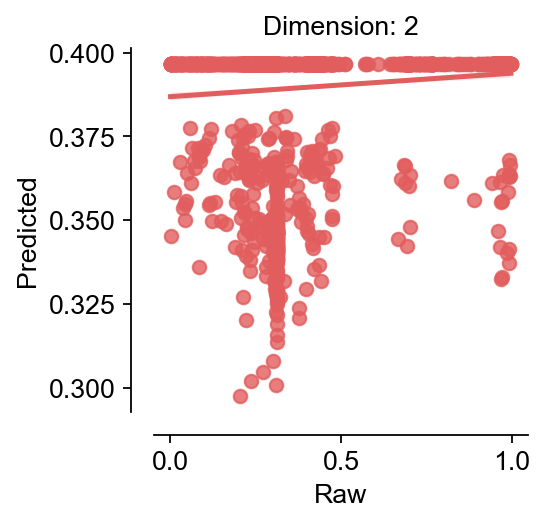

In [12]:
fig,ax=cfg_obj.plot_fitting(type='filter',
                            color='#e25d5d')

We can find that after filtering by an automatic threshold gate, only 76 genes are considered to be associated with pseudotime

In [13]:
cfg_obj.filter_coef.head()

,coef,abs(coef),values
GRPEL1,-0.015246,0.015246,0.330655
ZNF85,-0.009267,0.009267,0.192843


## Time-Series Gene Heatmap Visualization

Here, we presented `plot_heatmap` to visualize the Time-Series Gene Heatmap Visualization

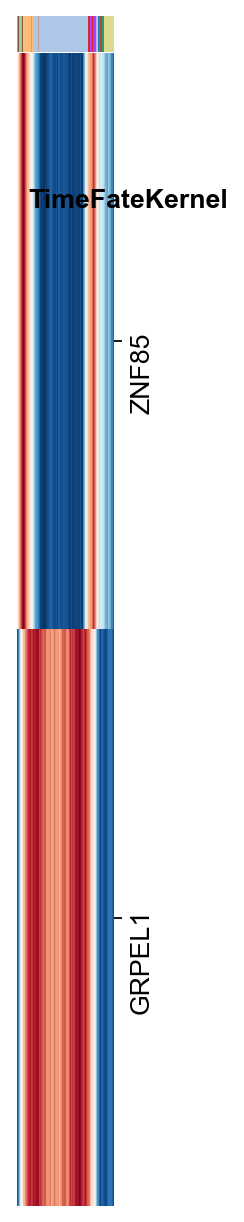

In [14]:
var_name=cfg_obj.filter_coef.index.tolist()
g=ov.utils.plot_heatmap(adata,var_names=var_name,
                  sortby='palantir_pseudotime',
                        col_color='celltype',
                 n_convolve=1000,figsize=(1,6),show=False,)

g.figure.set_size_inches(2, 8)
g.figure.suptitle('TimeFateKernel',x=0.25,y=0.83,
               horizontalalignment='left',
               fontsize=12,fontweight='bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),
                             fontsize=12)
plt.show()

## Density of Cells calculated

In this step, we will compute cell-state density using [Mellon](https://mellon.readthedocs.io/en/latest/notebooks/basic_tutorial.html)’s DensityEstimator class. Diffusion components computed above serve as inputs.

The compute densities, log_density can be visualized using UMAPs. We recommend the visualization of clipped log density. This procedure, which trims the very low density of outlier cells to the lower 5% percentile, provides richer visualization in 2D embeddings such as UMAPs.


In [15]:
cfg_obj.low_density(pca_key='X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
[2025-08-05 10:37:33,988] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2025-08-05 10:37:33,990] [INFO    ] Computing nearest neighbor distances.
[2025-08-05 10:37:38,524] [INFO    ] Using d=1.7355638982202313.
[2025-08-05 10:37:38,908] [INFO    ] Using covariance function Matern52(ls=0.001138197025284171).
[2025-08-05 10:37:38,910] [INFO    ] Computing 5,000 landmarks with k-means clustering (random_state=42).
[2025-08-05 10:37:47,783] [INFO    ] Using rank 5,000 covariance representation.
[2025-08-05 10:37:49,318] [INFO    ] Running inference using L-BFGS-B.


/home/huf/my_repo/omicverse/omicverse/utils/_scatterplot.py:483: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


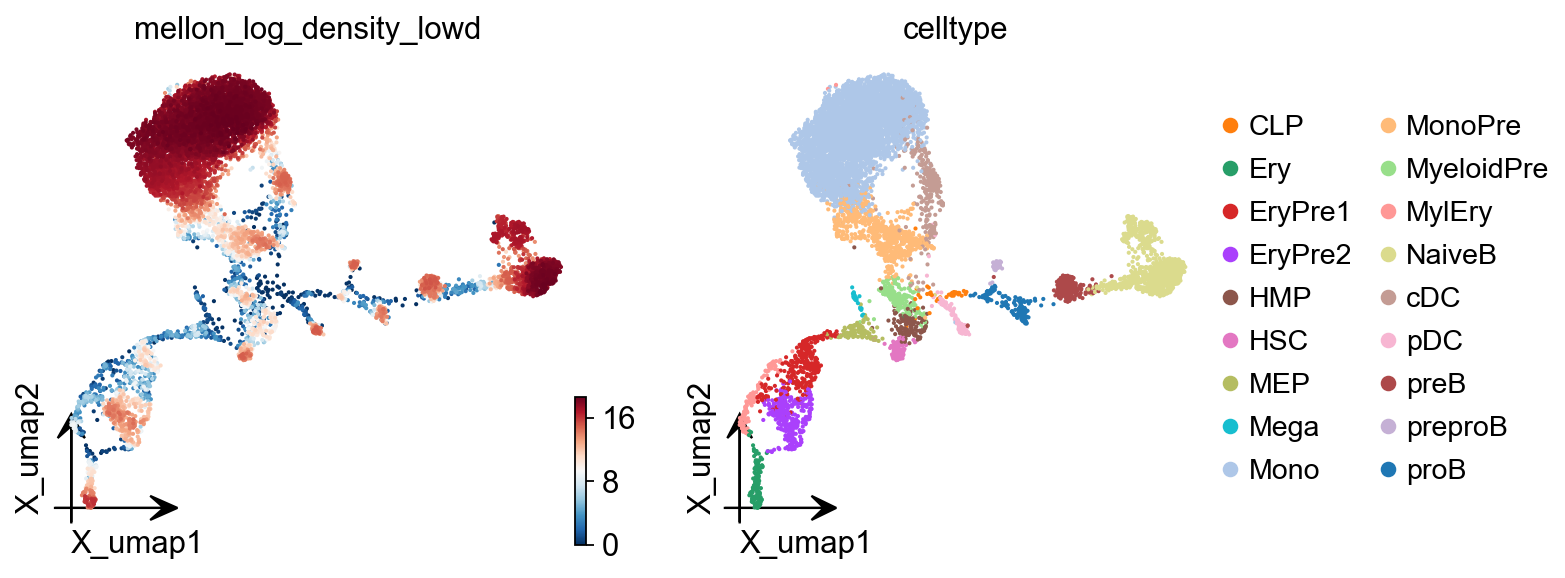

In [16]:
ov.pl.embedding(adata,
                basis='X_umap',
                color=['mellon_log_density_lowd','celltype'],
                frameon='small',
               cmap='RdBu_r')

## Fate Gene of B lineages

We selected **PreB** as the object of study and first used `leiden` clustering to obtain the differentiation categories of potential **PreB**

In [17]:
#ov.pp.neighbors(adata,use_rep='X_pca',
#               n_neighbors=15,n_pcs=30)
ov.pp.leiden(adata,resolution=2)

🖥️ Using Scanpy CPU Leiden...
running Leiden clustering


    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


/home/huf/my_repo/omicverse/omicverse/utils/_scatterplot.py:483: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: xlabel='X_umap1', ylabel='X_umap2'>

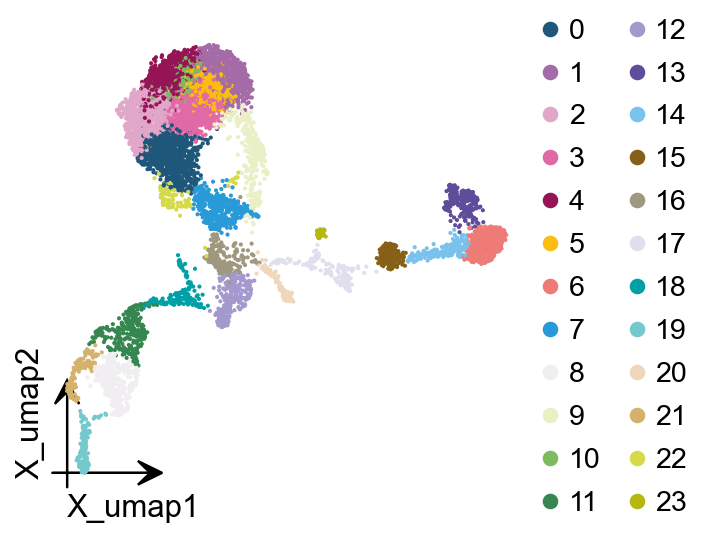

In [18]:
ov.pl.embedding(adata,
        basis="X_umap",
         color=['leiden'],title='',#size=15,
        show=False, #legend_loc=None, add_outline=False, 
        frameon='small',
        legend_fontoutline=2,#ax=ax
                 )

## Local variability or local change in expression

Local variability provides a measure of gene expression change for each cell-state. This is determined by comparison of a gene in a cell to its neighbor cell-states and can be computed using `palantir.utils.run_local_variability`

In [19]:
cfg_obj.lineage_score(cluster_key='leiden',lineage=['20','17'],
                      expression_key='MAGIC_imputed_data')
#palantir,mellon

Run low_density first


100%|██████████| 8627/8627 [00:16<00:00, 530.24it/s]


Calculating lineage score
The lineage score stored in adata.var['change_scores_lineage']


In [20]:
scores = adata.var["change_scores_lineage"]
scores.sort_values(ascending=False)

EBF1          0.001574
DIAPH3        0.001421
MIR924HG      0.001330
ATP8B4        0.001295
AL589693.1    0.001285
                ...   
AC104809.2    0.000000
AP001528.1    0.000000
CXCL1         0.000000
AC110741.1    0.000000
KCNE1B        0.000000
Name: change_scores_lineage, Length: 17226, dtype: float64

## Fate Genes of B linages

We take the intersection of temporally related genes with locally variant genes to obtain the genes that drive PreB differentiation.

In [21]:
preb_genes=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:20]
preb_genes

ZNF85     0.000016
GRPEL1    0.000007
Name: change_scores_lineage, dtype: float64

In [22]:
del adata.raw

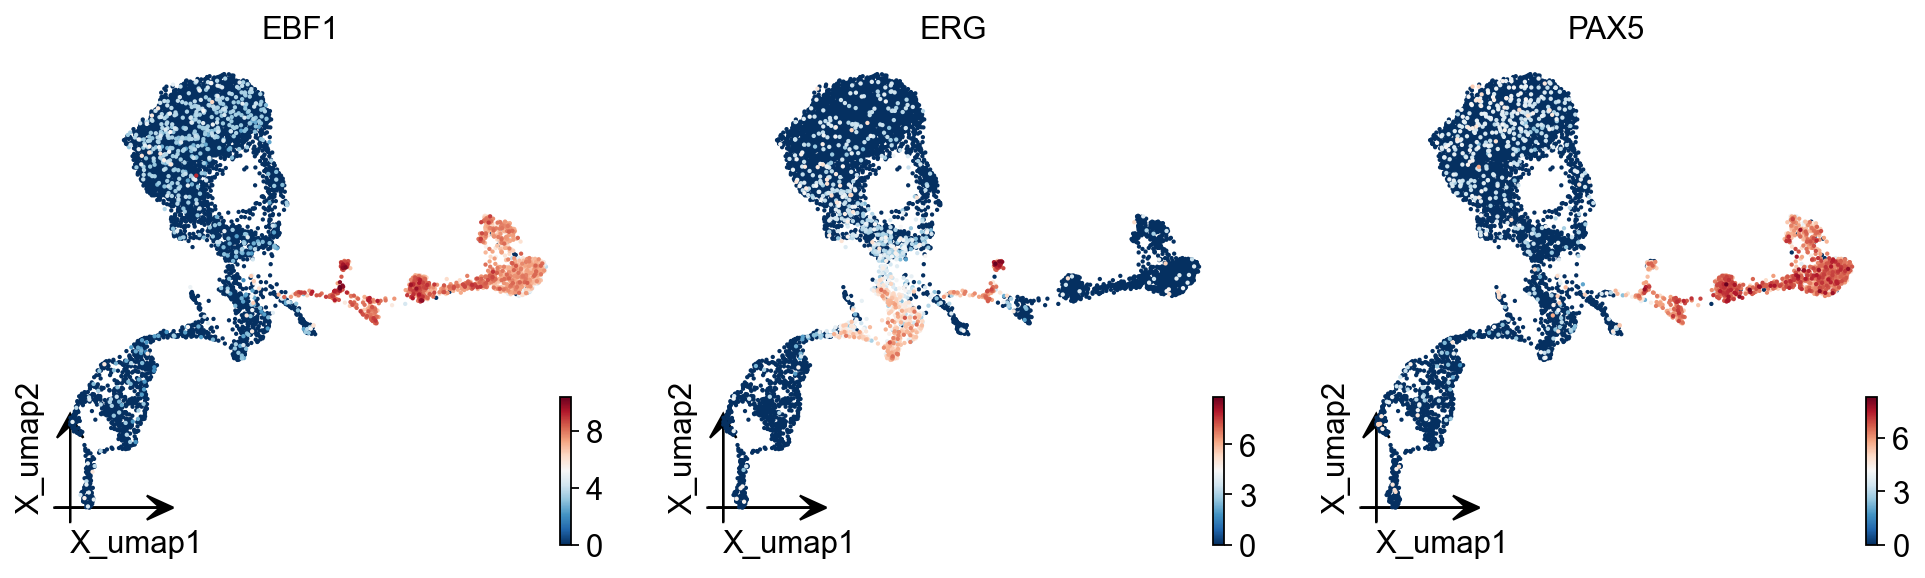

In [23]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
#fig, ax = plt.subplots(figsize=(3,3))

ov.pl.embedding(adata,
                basis='X_umap',
                color=['EBF1','ERG','PAX5'],
                frameon='small',
                size=15,
               cmap='RdBu_r',)

/home/huf/my_repo/omicverse/omicverse/utils/_scatterplot.py:483: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'B Cells\nscRNA-seq')

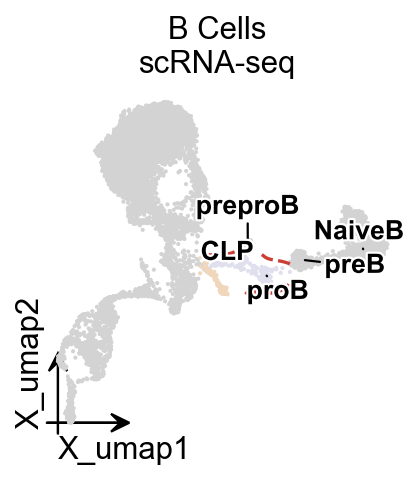

In [24]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(3,3))

ad=adata
visual_cluster=['20','17']
ad.obs['visual']=ad.obs['leiden'].copy()
ad.obs.loc[~ad.obs['leiden'].isin(visual_cluster),'visual']=None
ov.utils.embedding(ad,
                basis='X_umap',frameon='small',
                color=['visual'],
                legend_loc=None,
                #palette=ov.utils.blue_color+ov.utils.orange_color+ov.utils.red_color+ov.utils.green_color,
                show=False,
                  ax=ax)

ov.pl.embedding_adjust(
    ad,
    basis="X_umap",
    groupby='celltype',
    exclude=tuple(set(ad.obs['celltype'].cat.categories)-set(['CLP','proB', 'preproB', 'preB', 'NaiveB'])),  
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

ov.pl.contour(ax=ax,adata=ad,
        basis="X_umap",
        groupby='leiden',clusters=visual_cluster,
        contour_threshold=0.02,colors=ov.pl.red_color[2],linestyles='dashed')

plt.title('B Cells\nscRNA-seq', fontsize=14)
#plt.savefig(f'figures/hsc/umap-lineage-B-33.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/umap-lineage-B-33.pdf',dpi=300,bbox_inches='tight')


/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.o

[Text(1, 0.5, 'GRPEL1'), Text(1, 1.5, 'ZNF85')]

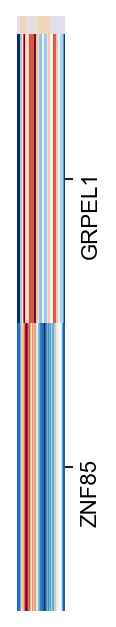

In [25]:
import matplotlib.pyplot as plt
g=ov.utils.plot_heatmap(ad[ad.obs['leiden'].isin(visual_cluster)],
                        var_names=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:10].index.tolist(),
                  sortby='palantir_pseudotime',col_color='leiden',yticklabels=True,
                 n_convolve=100,figsize=(1,6),show=False)

g.figure.set_size_inches(1, 4)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=10)

#plt.savefig(f'figures/hsc/heatmap-lineage-B-leiden-24.png',dpi=300,bbox_inches='tight')

/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/huf/my_repo/omicverse/omicverse/utils/_heatmap.py:396: ImplicitModificationWarning: Trying to modify attribute `.o

[Text(1, 0.5, 'GRPEL1'), Text(1, 1.5, 'ZNF85')]

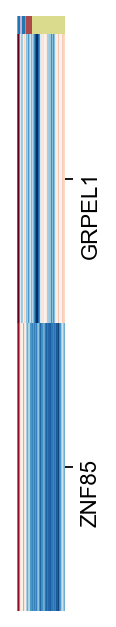

In [26]:
import matplotlib.pyplot as plt
g=ov.utils.plot_heatmap(ad[ad.obs['celltype'].isin(['CLP','proB','preproB','preB','NaiveB'])],
                        var_names=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:10].index.tolist(),
                  sortby='palantir_pseudotime',col_color='celltype',yticklabels=True,
                 n_convolve=100,figsize=(1,6),show=False)

g.figure.set_size_inches(1, 4)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(),fontsize=10)

#plt.savefig(f'figures/hsc/heatmap-lineage-B-ct-24.png',dpi=300,bbox_inches='tight')

/tmp/ipykernel_850935/1191334045.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
/tmp/ipykernel_850935/1191334045.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)


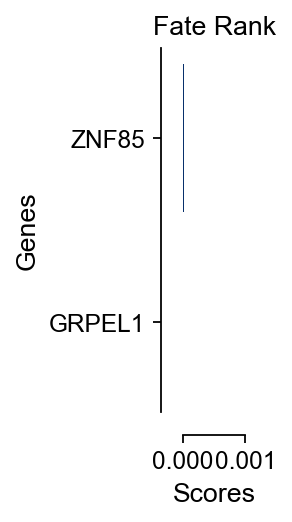

In [ ]:
# 创建横向柱状图
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(0.5, 3))

od_genes=scores.loc[cfg_obj.filter_coef.index].sort_values(ascending=False)[:10]

norm = plt.Normalize(min(od_genes.values), max(od_genes.values))
colors = cm.Blues(norm(od_genes.values))

plt.barh(od_genes.index, od_genes.values, color=colors)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

# 设置标签和标题
ax.set_xlabel('')
ax.set_ylabel('$R^2$', fontsize=13)
ax.set_title('', fontsize=13)
ax.set_xlim(0,0.001)
#ax.set_xticks(x + width)
ax.set_xticklabels(ax.get_xticklabels(),  fontsize=11,rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)

plt.xlabel('Scores',fontsize=12)
plt.ylabel('Genes',fontsize=12)
plt.title('Fate Rank',fontsize=12)
plt.gca().invert_yaxis()  # 反转y轴使得最高分数在顶部

#plt.savefig(f'figures/hsc/fr-lineage-B-33.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/fr-lineage-B-33.pdf',dpi=300,bbox_inches='tight')

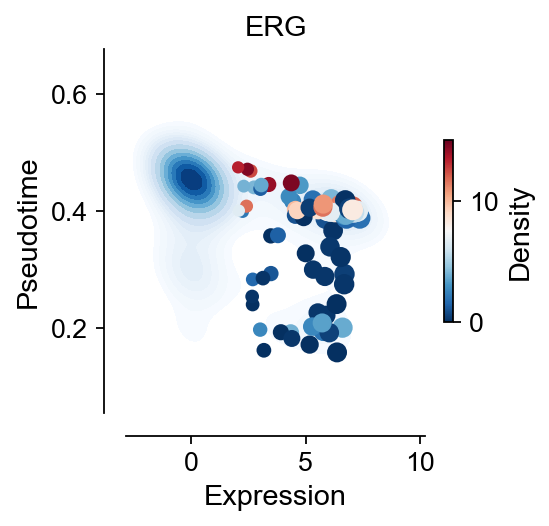

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(3,3))

gene='ERG'
visual_cluster=['20','17']

x=ad[ad.obs['leiden'].isin(visual_cluster),gene].to_df().values.reshape(-1)
y=ad.obs.loc[ad.obs['leiden'].isin(visual_cluster),'palantir_pseudotime'].values.reshape(-1)
z=ad.obs.loc[ad.obs['leiden'].isin(visual_cluster),'mellon_log_density_lowd'].values.reshape(-1)

sns.kdeplot(
        x=x, y=y,
        fill=True,
        cmap='Blues',
        #clip=(-5, 5), cut=10,
        thresh=0.1, levels=15,
        ax=ax,#cbar=True,
    )
scatter=ax.scatter(x,y,
           c=z, s=x*10,
           cmap='RdBu_r',
          )

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.grid(False)

plt.xlabel('Expression',fontsize=13)
plt.ylabel('Pseudotime',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(gene,fontsize=13)
cbar = plt.colorbar(scatter, ax=ax,shrink=0.5)
cbar.set_label('Density', fontsize=13)
cbar.ax.tick_params(labelsize=12)

#plt.savefig(f'figures/hsc/density-lineage-B-{gene}.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/density-lineage-B-{gene}.pdf',dpi=300,bbox_inches='tight')

#cbar.set_ticklabels(cbar.get_ticklabels(),fontsize=12)

<Axes: title={'center': 'ERG'}, xlabel='X_umap1', ylabel='X_umap2'>

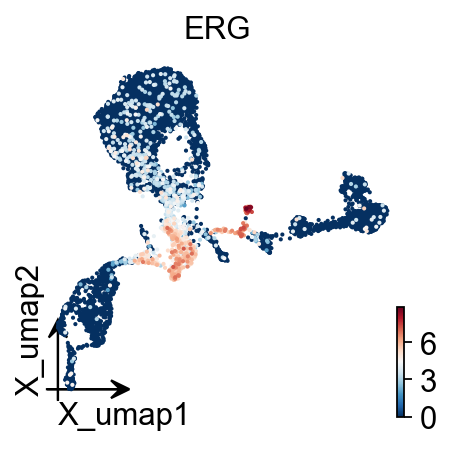

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))

#visual_cluster=['15','12']
#ad.obs['visual']=ad.obs['leiden'].copy()
#ad.obs.loc[~ad.obs['leiden'].isin(visual_cluster),'visual']=None
ov.utils.embedding(ad,
                basis='X_umap',frameon='small',
                color=[gene],
                legend_loc=None,
                #palette=ov.utils.blue_color+ov.utils.orange_color+ov.utils.red_color+ov.utils.green_color,
                show=False,
                ax=ax)
#plt.savefig(f'figures/hsc/umap-lineage-B-{gene}.png',dpi=300,bbox_inches='tight')
#plt.savefig(f'pdf/hsc/umap-lineage-B-{gene}.pdf',dpi=300,bbox_inches='tight')